# **Understanding Time Series Forecasting using different Machine Learning and Deep Learning models.**

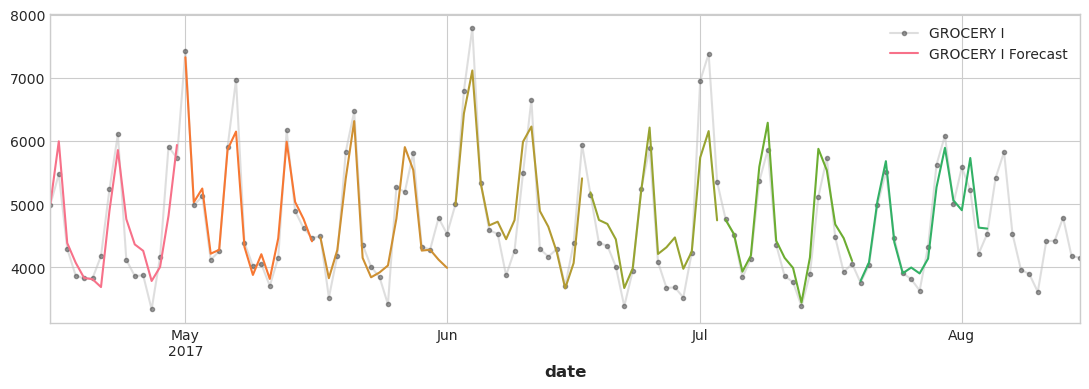

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.time_series.ex6 import *

# Setup notebook
from pathlib import Path
import ipywidgets as widgets
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import (create_multistep_example,
                                          load_multistep_data,
                                          make_lags,
                                          make_multistep_target,
                                          plot_multistep)
from learntools.time_series.utils import plot_periodogram, seasonal_plot
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

import itertools
import warnings

import statsmodels.api as sm
from pylab import rcParams
import scipy.stats as ss

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

# Introduction

### This Time Series for Sales Forecasting notebook using machine learning and deep learning methods showcases my KaggleX BIPOC cohort 2 learning and development experience.

Data used in this competition is from thousands of product families sold at Favorita stores from Corporación Favorita, a large Ecuadorian-based grocery retailer. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers.

Task: Build a model that more accurately predicts the unit sales for thousands of items sold at different Favorita stores for the next 16 days from the most recent available data from training set.

My KaggleX learning and development experience started with machine learning methods on tabular data, NLP and image data and eventually moved on to deep learning algorithms. Time series forecasting can be predicted using either machine learning or deep learning methods, with much longer processing times for neural network models.

The updated version of this notebook is updated with modifications on parameters and the neural network models used. It also briefly summarizes what I have learned from supervised machine learning using gradient boost regressions, S-ARIMA to building neural network models for deep learning. Comparison of all these different approaches and recommendations can be found on the Conclusion section of this notebook.

**This notebook will build the following different models that can be used for Time Series Sales Forecasting:**

**1. XGBRegressor** Predicting a given variable (i.e. sales) for future time series applies for this regression model when prediction of future values are dependent on historical values in sequence. The training data was created using DeterministicProcess to acount for time trends and seasonality. The prediction from this model will be submitted to this Time Series competition. All other models are intended for learning and development.

**2. ARIMA** AutoRegressive Integrated Moving Average - A widely used model for statistical time series forecasting methods. For this data set, Seasonal ARIMA (SARIMA) will be used to include seasonality contribution to the forecast. 

**Deep Learning models for univariate time series forecasting:**

**4. Convolutional Neural Network (CNN)**

**5. Long Short-Term Memory Neural Network (LSTM)**

**6. CNN-LSTM**

# XGBRegressor

In [3]:
#Load data
comp_dir = Path('../input/store-sales-time-series-forecasting')


store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales','onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

In [4]:
#define target
y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]

# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

In [5]:
#Model

model = RegressorChain(base_estimator=XGBRegressor())
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

In [6]:
#Load test data
test_df = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
test_df['date'] = test_df.date.dt.to_period('D')
test_df = test_df.set_index(['store_nbr', 'family', 'date']).sort_index()

# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)

In [7]:
y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(test_df.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)

# EDA

In [8]:
train = pd.read_csv('../input/store-sales-time-series-forecasting/train.csv')
test = pd.read_csv('../input/store-sales-time-series-forecasting/test.csv')

In [9]:
train['date'] = pd.to_datetime(train['date'])
train.rename(columns={'sales': 'Sales'}, inplace=True)
train['Year'] = train['date'].dt.year
train['Month'] = train['date'].dt.month

In [10]:
# Inspecting time series and rolling mean:

crossing = train[['date', 'Sales']].groupby('date').sum()
tseries = train.groupby(['date'])['Sales'].agg(
    ['sum']).reset_index().rename(columns={'sum': 'Sales'})
tseries = tseries.set_index('date')

In [11]:
y = tseries['Sales'].resample('MS').mean()

In [12]:
y['2017':]

date
2017-01-01    849295.481797
2017-02-01    830361.156248
2017-03-01    861419.925512
2017-04-01    863176.949652
2017-05-01    868124.104858
2017-06-01    856094.070833
2017-07-01    871337.985995
2017-08-01    828888.196052
Freq: MS, Name: Sales, dtype: float64

## Decomposing the Time Series -trend, seasonality , noise

Patterns appear when we decompose the series and plot the data. The time-series has seasonality pattern, peaking rightbefore year end. Sales had been trending upward troughout the year.

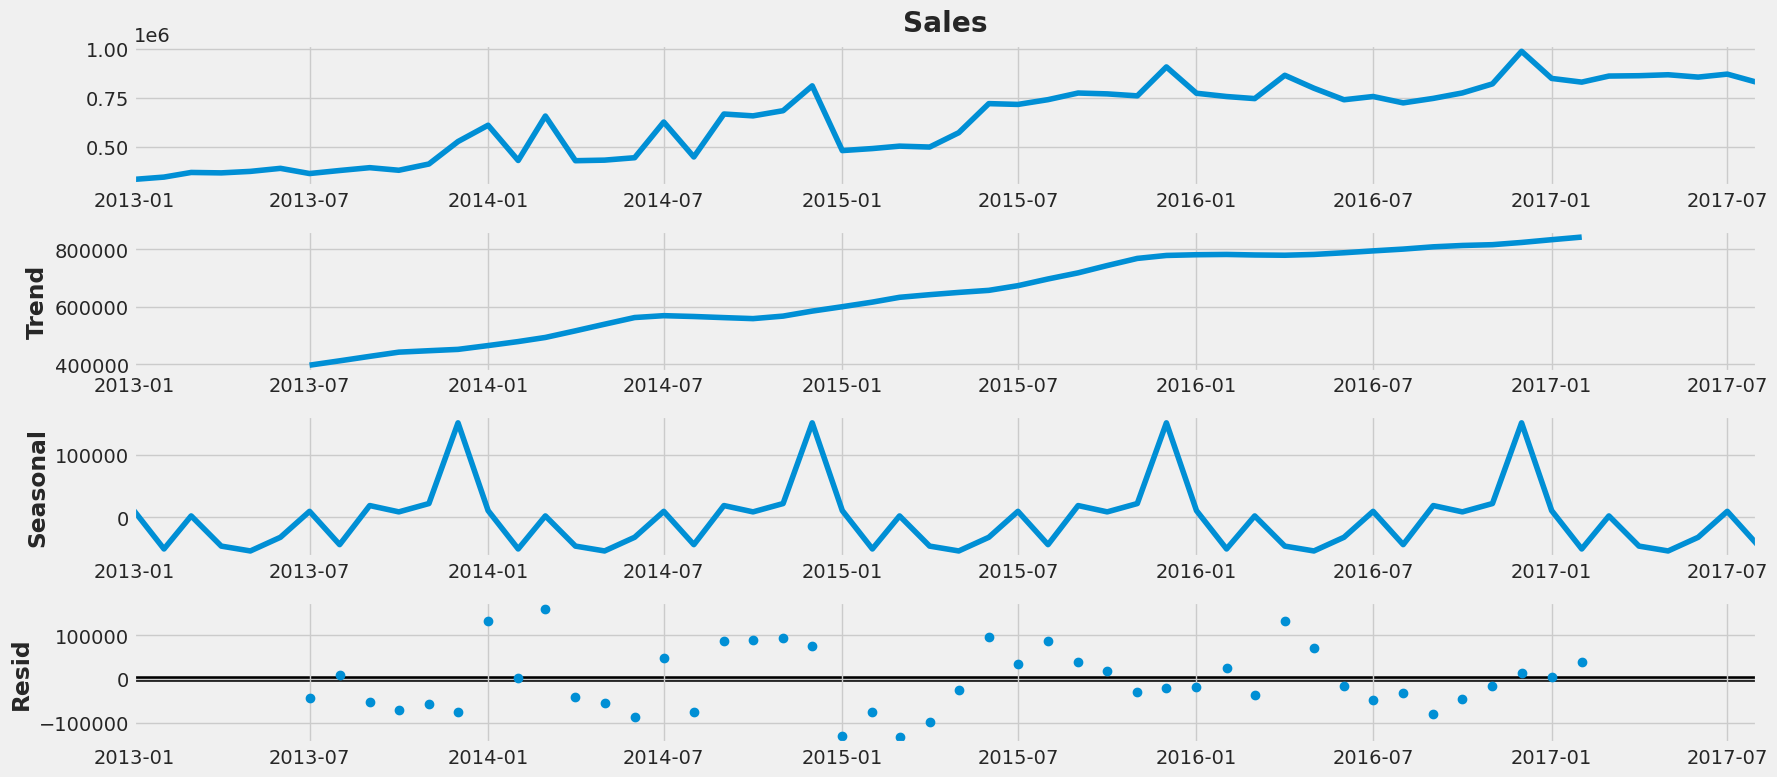

In [13]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

# ARIMA (Seasonal ARIMA)

In [14]:
# Based on a previous run, evaluation parameters of PDQ at (1,1,0) yielded lowest MSE
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [15]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45700D+01    |proj g|=  1.98953D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.990D-08   1.457D+01
  F =   14.570049222509899     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1633.8455129211088
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variabl

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


  ys=-9.321E+01  -gs= 5.503E-01 BFGS update SKIPPED

At iterate    5    f=  1.19552D+01    |proj g|=  1.72779D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6    110      4     3     0   1.728D+04   1.196D+01
  F =   11.955181061302868     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1342.9802788659213
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04199D+01    |proj g|=  7.48084D-05

           * * *

Tit  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.02061D+01    |proj g|=  5.61554D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     14      1     0     0   4.061D-06   1.021D+01
  F =   10.206042398279340     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1149.0767486072862
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.62342D+00    |proj g|=  4.89120D-06

           * * *

Tit   = total number of iterations
Tnf   = total number o


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1539.6423649711833
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.40312D+01    |proj g|=  2.11154D-01
  ys=-9.854E-04  -gs= 2.154E-03 BFGS update SKIPPED

At iterate    5    f=  1.39805D+01    |proj g|=  4.25371D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     27      1     1     0   4.293D-06   1.398D+01
  F =   13.980504426850201     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(0, 0, 0,

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.07825D+01    |proj g|=  1.96191D-02

At iterate   10    f=  1.07778D+01    |proj g|=  5.16512D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     13      1     0     0   1.548D-06   1.078D+01
  F =   10.777801953185499     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1215.1138187567758
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.60286D+00    |proj g|=  2.13380D-01

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


  ys=-1.033E+02  -gs= 5.330E-01 BFGS update SKIPPED
  ys=-5.083E+01  -gs= 5.302E-01 BFGS update SKIPPED

At iterate    5    f=  1.12998D+01    |proj g|=  8.32090D+04
  ys=-1.043E+01  -gs= 5.063E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6    106      3     3     0   8.321D+04   1.130D+01
  F =   11.299797607802846     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:1269.5773320739188
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.99372D+00    |proj g|=  3.72609D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explor


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7    104      6     4     0   1.074D+04   1.111D+01
  F =   11.110388238455316     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:1250.3634827069955
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21495D+01    |proj g|=  8.09236D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explor

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:1061.2723243663336
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.12896D+00    |proj g|=  7.56683D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      6      1     0     0   3.811D-06   7.123D+00
  F =   7.1227378251055793     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:803.7466364118249
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04363D+01    |proj g|=  9.36208D-01

At iterate    5    f=  9.99931D+00    |proj g|=  1.45076D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     18      1     0     0   8.581D-06   9.998D+00
  F =   9.9982879984791602     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:1125.808255829666
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.23586D+01    |proj g|=  3.03558D-01

At iterate   10    f=  1.23557D+01    |proj g|=  3.09160D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   2.066D-05   1.236D+01
  F =   12.355746141601662     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1389.8435678593862
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.92346D+02    |proj g|=  1.11762D+03

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.01139D+01    |proj g|=  1.38320D+00

At iterate   10    f=  9.66721D+00    |proj g|=  4.15938D-01

At iterate   15    f=  9.64532D+00    |proj g|=  8.60110D-02

At iterate   20    f=  9.64516D+00    |proj g|=  4.89351D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     24      1     0     0   4.894D-06   9.645D+00
  F =   9.6451619126915471     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:1090.2581342214532
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1086.9057206884193
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83034D+00    |proj g|=  5.29035D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.290D-06   9.830D+00
  F =   9.8303399112262522     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:1104.9980700573403
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.21482D+01    |proj g|=  1.54827D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      9      1     0     0   1.548D-06   1.215D+01
  F =   12.148206431578554     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:1366.599120336798
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.50122D+00    |proj g|=  5.57469D-01

At iterate    5    f=  9.40747D+00    |proj g|=  1.45426D-03

At iterate   1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.40454D+00    |proj g|=  1.14004D-02

At iterate   10    f=  9.40431D+00    |proj g|=  5.13412D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     15      1     0     0   5.650D-06   9.404D+00
  F =   9.4043106164540244     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1063.2827890428507
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.86549D+00    |proj g|=  2.96977D-02

At iterate   

 This problem is unconstrained.


## SARIMA model using pdq = (1,1,1) and P, D, Q = (1, 1, 0) with and 12 month lag

In [16]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.86549D+00    |proj g|=  2.96977D-02

At iterate    5    f=  6.85589D+00    |proj g|=  1.39461D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     22      1     0     0   1.296D-05   6.856D+00
  F =   6.8558086109880652     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

## Validate the model using diagnostic plots

Observations: 

The residual errors fluctuate around a mean of zero and have a uniform variance.

The density plot suggest near normal distribution..

Most of the points fall in line with the red line. Distribution is not skewed. Normal data distribution is observed.

The Correlogram shows no autocorrelation on the residual errors. 

Model is a good fit to proceed to forecasting.

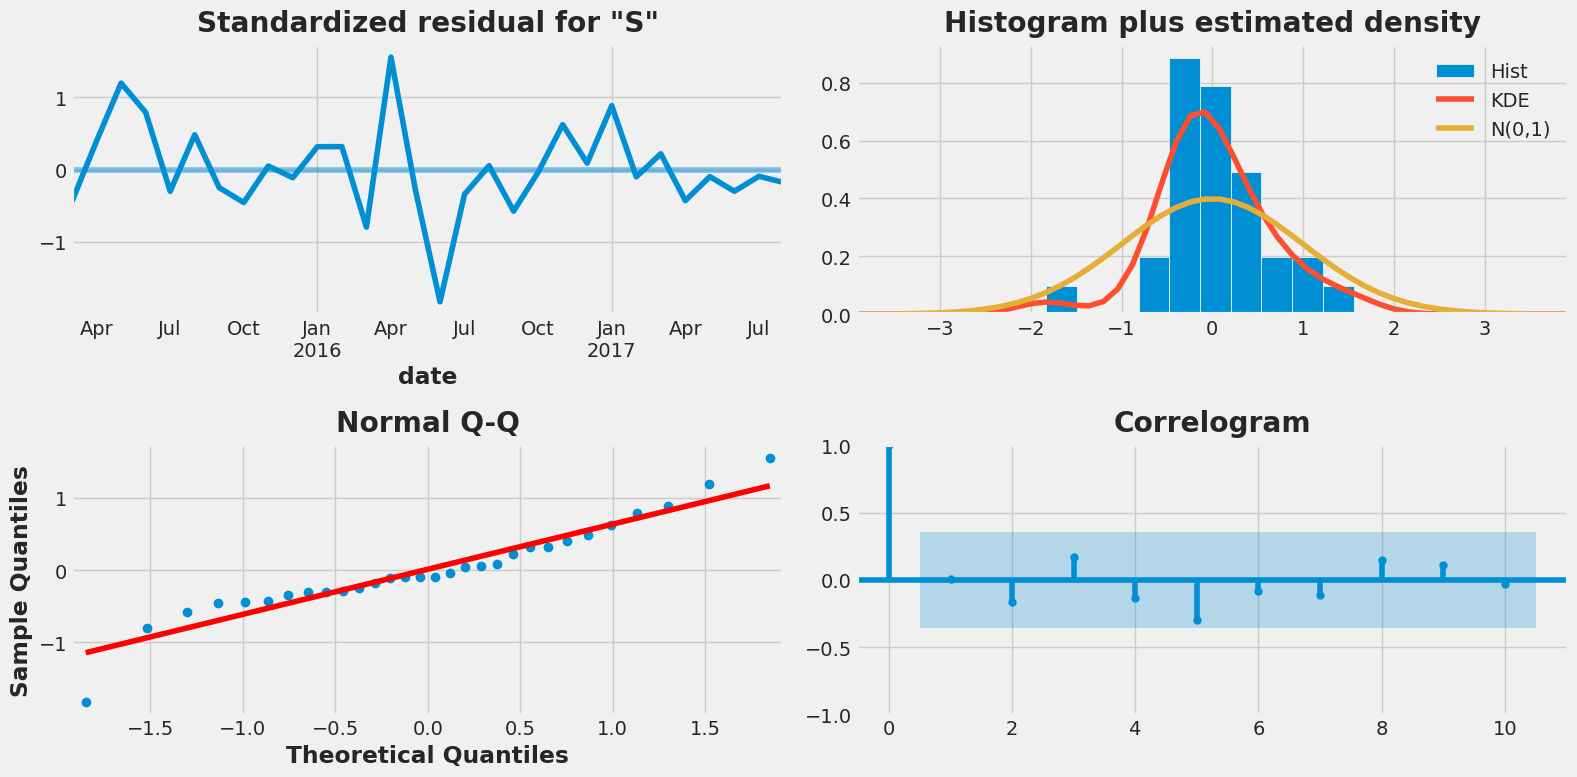

In [17]:
results.plot_diagnostics(figsize=(16, 8)) # Investigating the results:
plt.show()

## Validating forecasts:

To understand the accuracy of the forecast, predicted sales are compared to actual sales data. In the image below, forecast date is to start on 04-1-2017 to the end of the data. Based on the image below, forecast prediction looks acceptable as it follows the actual data closely.

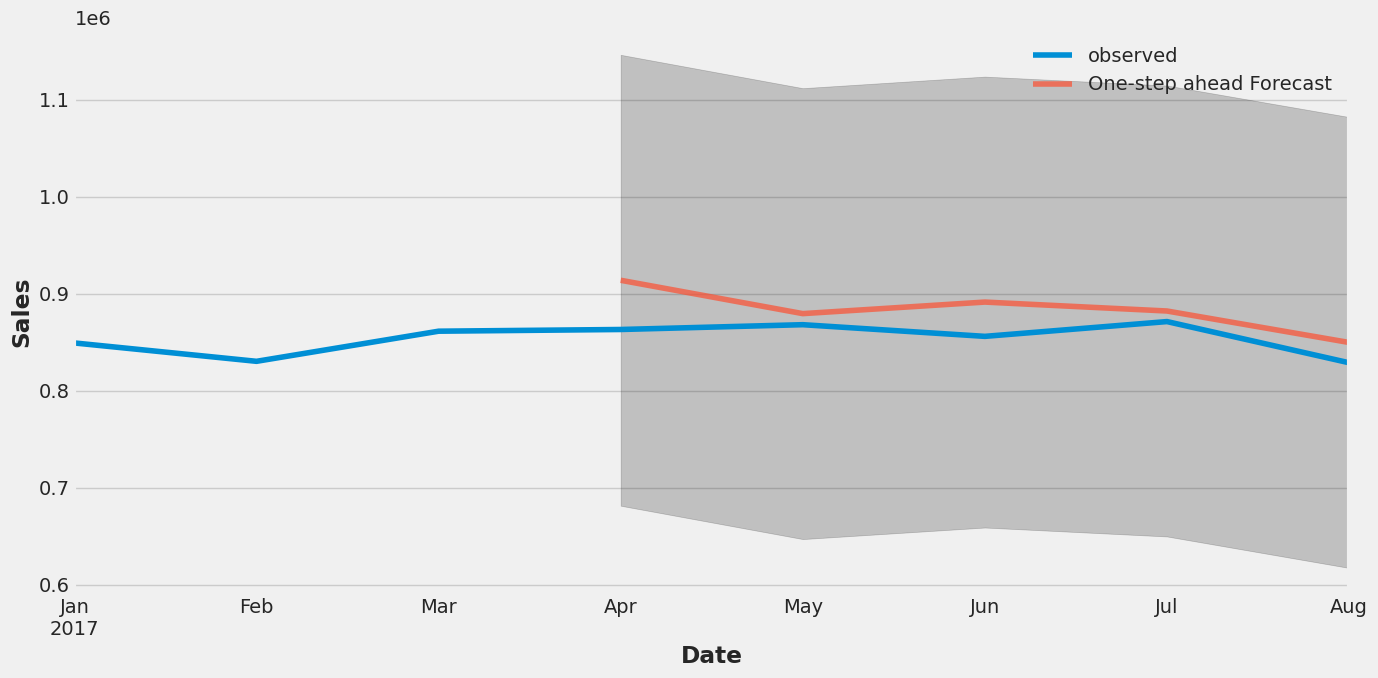

In [18]:
pred = results.get_prediction(start=pd.to_datetime('2017-04-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()

plt.show()

## Forecasting

Based on image below, forecast looks acceptable as it follows seasonality of a upward trend in sales shortly before year end similar to previous years.

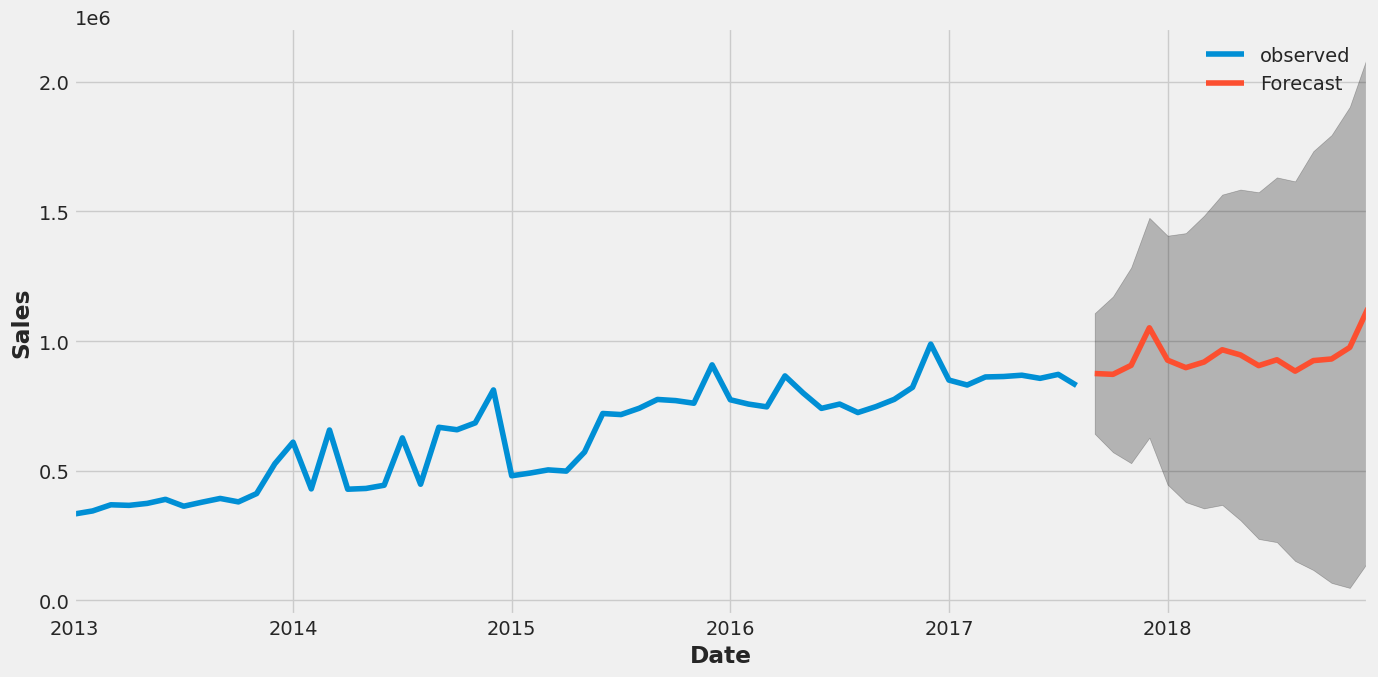

In [19]:
pred_uc = results.get_forecast(steps=16)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

In [20]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 30039.16


# Data Processing for Neural Networks 

In [21]:
!pip install chart_studio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 2.4 MB/s eta 0:00:00


In [22]:
#Set up 
import warnings
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
from chart_studio import plotly
from plotly.offline import init_notebook_mode, iplot
from keras.layers import Dropout

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

In [23]:
train_df = pd.read_csv('../input/store-sales-time-series-forecasting/train.csv', parse_dates=['date'])
test_df = pd.read_csv('../input/store-sales-time-series-forecasting/test.csv', parse_dates=['date'])

In [24]:
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
label = le.fit_transform(train_df['family'])
 
# printing label
label

array([ 0,  1,  2, ..., 30, 31, 32])

In [25]:
label2 = le.fit_transform(train_df['store_nbr'])
label2

array([0, 0, 0, ..., 8, 8, 8])

In [26]:
train_df.drop(("family"), axis=1, inplace=True)
train_df.drop(("store_nbr"), axis=1, inplace=True)
 
# Appending the array to dataFrame

train_df["family"] = label
train_df["store_nbr"] = label2

In [27]:
print('Min date from train set: %s' % train_df['date'].min().date())
print('Max date from train set: %s' % train_df['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2017-08-15


In [28]:
lag_size = (test_df['date'].max().date() - train_df['date'].max().date()).days
print('Max date from train set: %s' % train_df['date'].max().date())
print('Max date from test set: %s' % test_df['date'].max().date())
print('Forecast lag size', lag_size)

Max date from train set: 2017-08-15
Max date from test set: 2017-08-31
Forecast lag size 16


## Transform data

Time series data has to be transformed into supervised learning data

In [29]:
train_df = train_df[(train_df['date'] >= '2017-01-01')] #working on data starting from this date

In [30]:
#Rearrange data
train_gp = train_df.sort_values('date').groupby(['family', 'store_nbr', 'date','onpromotion'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['family', 'store_nbr', 'date', 'onpromotion','sales']
train_gp.head()

,family,store_nbr,date,onpromotion,sales
0,0,0,2017-01-01,0,0.0
1,0,0,2017-01-02,0,5.0
2,0,0,2017-01-03,0,4.0
3,0,0,2017-01-04,0,1.0
4,0,0,2017-01-05,0,2.0


In [31]:
# Transform series to supervised learning 

def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [32]:
#use the current timestep and the last 29 to forecast 16 days ahead
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

,family(t-29),store_nbr(t-29),onpromotion(t-29),sales(t-29),family(t-28),store_nbr(t-28),onpromotion(t-28),sales(t-28),family(t-27),store_nbr(t-27),...,onpromotion(t-1),sales(t-1),family(t),store_nbr(t),onpromotion(t),sales(t),family(t+16),store_nbr(t+16),onpromotion(t+16),sales(t+16)
29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0,0,0,3.0,0.0,0.0,0.0,3.0
30,0.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,3.0,0,0,0,5.0,0.0,0.0,0.0,3.0
31,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,5.0,0,0,0,7.0,0.0,0.0,0.0,7.0
32,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,7.0,0,0,0,3.0,0.0,0.0,0.0,3.0
33,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,3.0,0,0,0,1.0,0.0,0.0,0.0,0.0


In [33]:
#Drop rows with different item or store values than the shifted columns

last_item = 'family(t-%d)' % window
last_store = 'store_nbr(t-%d)' % window
last_onpromotion = 'onpromotion(t-%d)' % window
series = series[(series['store_nbr(t)'] == series[last_store])]
series = series[(series['family(t)'] == series[last_item])]
series = series[(series['onpromotion(t)'] == series[last_item])]

In [34]:
#Remove unwanted columns
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['family', 'store_nbr','onpromotion']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['family', 'store_nbr','onpromotion']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['family(t)', 'store_nbr(t)'], axis=1, inplace=True)

### Split data into train and test

In [35]:
# Label
labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.2, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (10364, 31)
Validation set shape (2592, 31)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),onpromotion(t),sales(t)
4500,7.0,3.0,12.0,15.0,3.0,7.0,9.0,8.0,2.0,5.0,...,6.0,9.0,21.0,20.0,11.0,4.0,13.0,6.0,0,3.0
9652,4.0,5.0,3.0,2.0,3.0,3.0,2.0,3.0,9.0,9.0,...,4.0,1.0,2.0,6.0,1.0,0.0,2.0,1.0,0,0.0
10976,10.0,11.0,8.0,19.0,18.0,11.0,26.0,30.0,15.0,11.0,...,5.0,15.0,16.0,14.0,13.0,20.0,9.0,10.0,0,5.0
5895,7.0,3.0,1.0,3.0,4.0,9.0,0.0,1.0,6.0,5.0,...,5.0,7.0,1.0,4.0,16.0,8.0,1.0,2.0,0,3.0
73389,198.0,187.0,243.0,421.0,237.0,140.0,186.0,144.0,134.0,262.0,...,187.0,229.0,222.0,307.0,176.0,196.0,134.0,174.0,5,149.0


# CNN

For this Convolutional Neural Network model, the number of input time steps is defined as 1 and the number of features as 2 via the input_shape argument. One convolutional hidden layer is used followed by a max pooling layer and fully-connected layer. The filter maps are then flattened before being interpreted by dense layers and output a prediction. The model uses Adam version of stochastic gradient descent and optimizes the mean squared error (‘mse‘) loss function.The model is then fit to the training data for predictions.

I used one convolutional layer with kernel size =2, stride =1, Rectified Linear Unit activation (ReLu). After the MaxPooling, data was flattened and dense layers added with activation of ReLu. The model is compiled using a loss and optimizer arguments. Dropout set at 0.2 to avoid overfitting and improve performance.

In [36]:
# Set parameters
epochs = 1000
batch = 128
lr = 0.00001
adam = optimizers.Adam(lr)

### Reshape for CNN 

In [37]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (10364, 31, 1)
Validation set shape (2592, 31, 1)


In [38]:
cnn = Sequential()
cnn.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense (128, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense (128, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense (34, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense(1))
cnn.compile(loss='mse', optimizer=adam)
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 128)           384       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 128)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 128)               245888    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                        

In [39]:
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [40]:
cnn_history = cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), callbacks=[callback],epochs=epochs, verbose=2)

Epoch 1/1000
324/324 - 3s - loss: 34180.5039 - val_loss: 11530.3320 - 3s/epoch - 11ms/step
Epoch 2/1000
324/324 - 2s - loss: 19338.3691 - val_loss: 7593.5479 - 2s/epoch - 7ms/step
Epoch 3/1000
324/324 - 2s - loss: 14073.4404 - val_loss: 7282.8613 - 2s/epoch - 7ms/step
Epoch 4/1000
324/324 - 2s - loss: 12553.1914 - val_loss: 6793.6289 - 2s/epoch - 7ms/step
Epoch 5/1000
324/324 - 2s - loss: 13540.3213 - val_loss: 6799.9863 - 2s/epoch - 7ms/step
Epoch 6/1000
324/324 - 2s - loss: 14195.2871 - val_loss: 7894.5215 - 2s/epoch - 7ms/step
Epoch 7/1000
324/324 - 2s - loss: 11873.3389 - val_loss: 6337.9990 - 2s/epoch - 7ms/step
Epoch 8/1000
324/324 - 2s - loss: 10438.9629 - val_loss: 6318.7515 - 2s/epoch - 7ms/step
Epoch 9/1000
324/324 - 2s - loss: 12598.6572 - val_loss: 6654.1533 - 2s/epoch - 7ms/step
Epoch 10/1000
324/324 - 2s - loss: 11619.9727 - val_loss: 5921.0903 - 2s/epoch - 7ms/step
Epoch 11/1000
324/324 - 3s - loss: 13781.3447 - val_loss: 5851.4243 - 3s/epoch - 8ms/step
Epoch 12/1000
324

# LSTM


For Long Short-Term Memory Neural Network, a recurrent neural network model, the number of input time steps is defined as 1 and the number of features as 2 via the input_shape argument.

This will use one LSTM layer to process input sub-sequence of the time step, followed by dense layers to interpret the summary of the input sequence. The model uses the efficient Adam version of stochastic gradient descent and optimizes the mean squared error (‘mse‘) loss function.

The model is then fit to the training data for predictions.

In [41]:
epochs = 1000
batch = 128
lr = 0.00001
adam = optimizers.Adam(lr)

In [42]:
lstm = Sequential()
lstm.add(LSTM(256, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
lstm.add(Dense(128))
lstm.add(Dropout(0.2))
lstm.add(Dense(64))
lstm.add(Dense(32))
lstm.add(Dense(1))
lstm.compile(loss='mse', optimizer=adam)
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 307,457
Trainable params: 307,457
Non-tr

In [43]:
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [44]:
lstm_history = lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid),callbacks=[callback], epochs=epochs, verbose=2)

Epoch 1/1000
324/324 - 29s - loss: 81919.7500 - val_loss: 50184.9922 - 29s/epoch - 89ms/step
Epoch 2/1000
324/324 - 26s - loss: 41402.3906 - val_loss: 33338.4141 - 26s/epoch - 79ms/step
Epoch 3/1000
324/324 - 26s - loss: 32302.4590 - val_loss: 25997.5898 - 26s/epoch - 81ms/step
Epoch 4/1000
324/324 - 25s - loss: 33104.8789 - val_loss: 23187.4375 - 25s/epoch - 78ms/step
Epoch 5/1000
324/324 - 24s - loss: 33119.1211 - val_loss: 27561.0176 - 24s/epoch - 75ms/step
Epoch 6/1000
324/324 - 24s - loss: 27407.6230 - val_loss: 27320.5312 - 24s/epoch - 75ms/step
Epoch 7/1000
324/324 - 28s - loss: 47547.6875 - val_loss: 27239.2988 - 28s/epoch - 88ms/step
Epoch 8/1000
324/324 - 26s - loss: 31846.2285 - val_loss: 23801.1953 - 26s/epoch - 79ms/step
Epoch 9/1000
324/324 - 26s - loss: 27584.4785 - val_loss: 18391.5918 - 26s/epoch - 80ms/step
Epoch 10/1000
324/324 - 25s - loss: 24279.9531 - val_loss: 19102.3730 - 25s/epoch - 77ms/step
Epoch 11/1000
324/324 - 25s - loss: 24584.0117 - val_loss: 19140.6250

# CNN-LSTM


According to some research, this hybrid model is more efficient in predictions, precisions and stability as it merges CNN and LTSM learning architectures.

In this hybrid model, each sample is divided into subsequences where CNN will read each subsequence and LSTM will read the interpretations from these subsequences.

This CNN which has 2 timesteps per subsequence and 1 feature is wrapped (in TimeDistributed) which applies a layer to every temporal slice of an input.

The LSTM interprets the results before the model makes a prediction.

The model uses the efficient Adam version of stochastic gradient descent and optimizes the mean squared error (‘mse‘) loss function.

In [45]:
epochs = 1000
batch = 128
lr = 0.00001
adam = optimizers.Adam(lr)

### Reshape data for CNN-LSTM

In [46]:
subsequences = 1
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (10364, 1, 31, 1)
Validation set shape (2592, 1, 31, 1)


In [47]:
cnn_lstm = Sequential()
cnn_lstm.add(TimeDistributed(Conv1D(filters=128, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
cnn_lstm.add(TimeDistributed(Flatten()))
cnn_lstm.add(TimeDistributed(Dropout(0.2)))
cnn_lstm.add(LSTM(64, activation='relu'))
cnn_lstm.add(Dense(32))
cnn_lstm.add(Dense(1))
cnn_lstm.compile(loss='mse', optimizer=adam)

In [48]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [49]:
cnn_lstm_history = cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid),callbacks=[callback], epochs=epochs, verbose=2)

Epoch 1/1000
324/324 - 5s - loss: 45418.8242 - val_loss: 17820.0215 - 5s/epoch - 16ms/step
Epoch 2/1000
324/324 - 3s - loss: 12117.3877 - val_loss: 7317.9404 - 3s/epoch - 11ms/step
Epoch 3/1000
324/324 - 3s - loss: 9822.6807 - val_loss: 7107.6938 - 3s/epoch - 10ms/step
Epoch 4/1000
324/324 - 3s - loss: 10311.8945 - val_loss: 6707.2231 - 3s/epoch - 10ms/step
Epoch 5/1000
324/324 - 3s - loss: 9240.6758 - val_loss: 6439.3262 - 3s/epoch - 10ms/step
Epoch 6/1000
324/324 - 3s - loss: 10405.3359 - val_loss: 6129.6670 - 3s/epoch - 10ms/step
Epoch 7/1000
324/324 - 3s - loss: 9099.6963 - val_loss: 6118.8760 - 3s/epoch - 10ms/step
Epoch 8/1000
324/324 - 3s - loss: 8907.2773 - val_loss: 5637.8403 - 3s/epoch - 10ms/step
Epoch 9/1000
324/324 - 3s - loss: 9235.9043 - val_loss: 5774.5049 - 3s/epoch - 10ms/step
Epoch 10/1000
324/324 - 3s - loss: 8896.6670 - val_loss: 5942.0469 - 3s/epoch - 10ms/step
Epoch 11/1000
324/324 - 3s - loss: 8155.6665 - val_loss: 5852.3389 - 3s/epoch - 10ms/step
Epoch 12/1000


# Evaluate Learning Curves

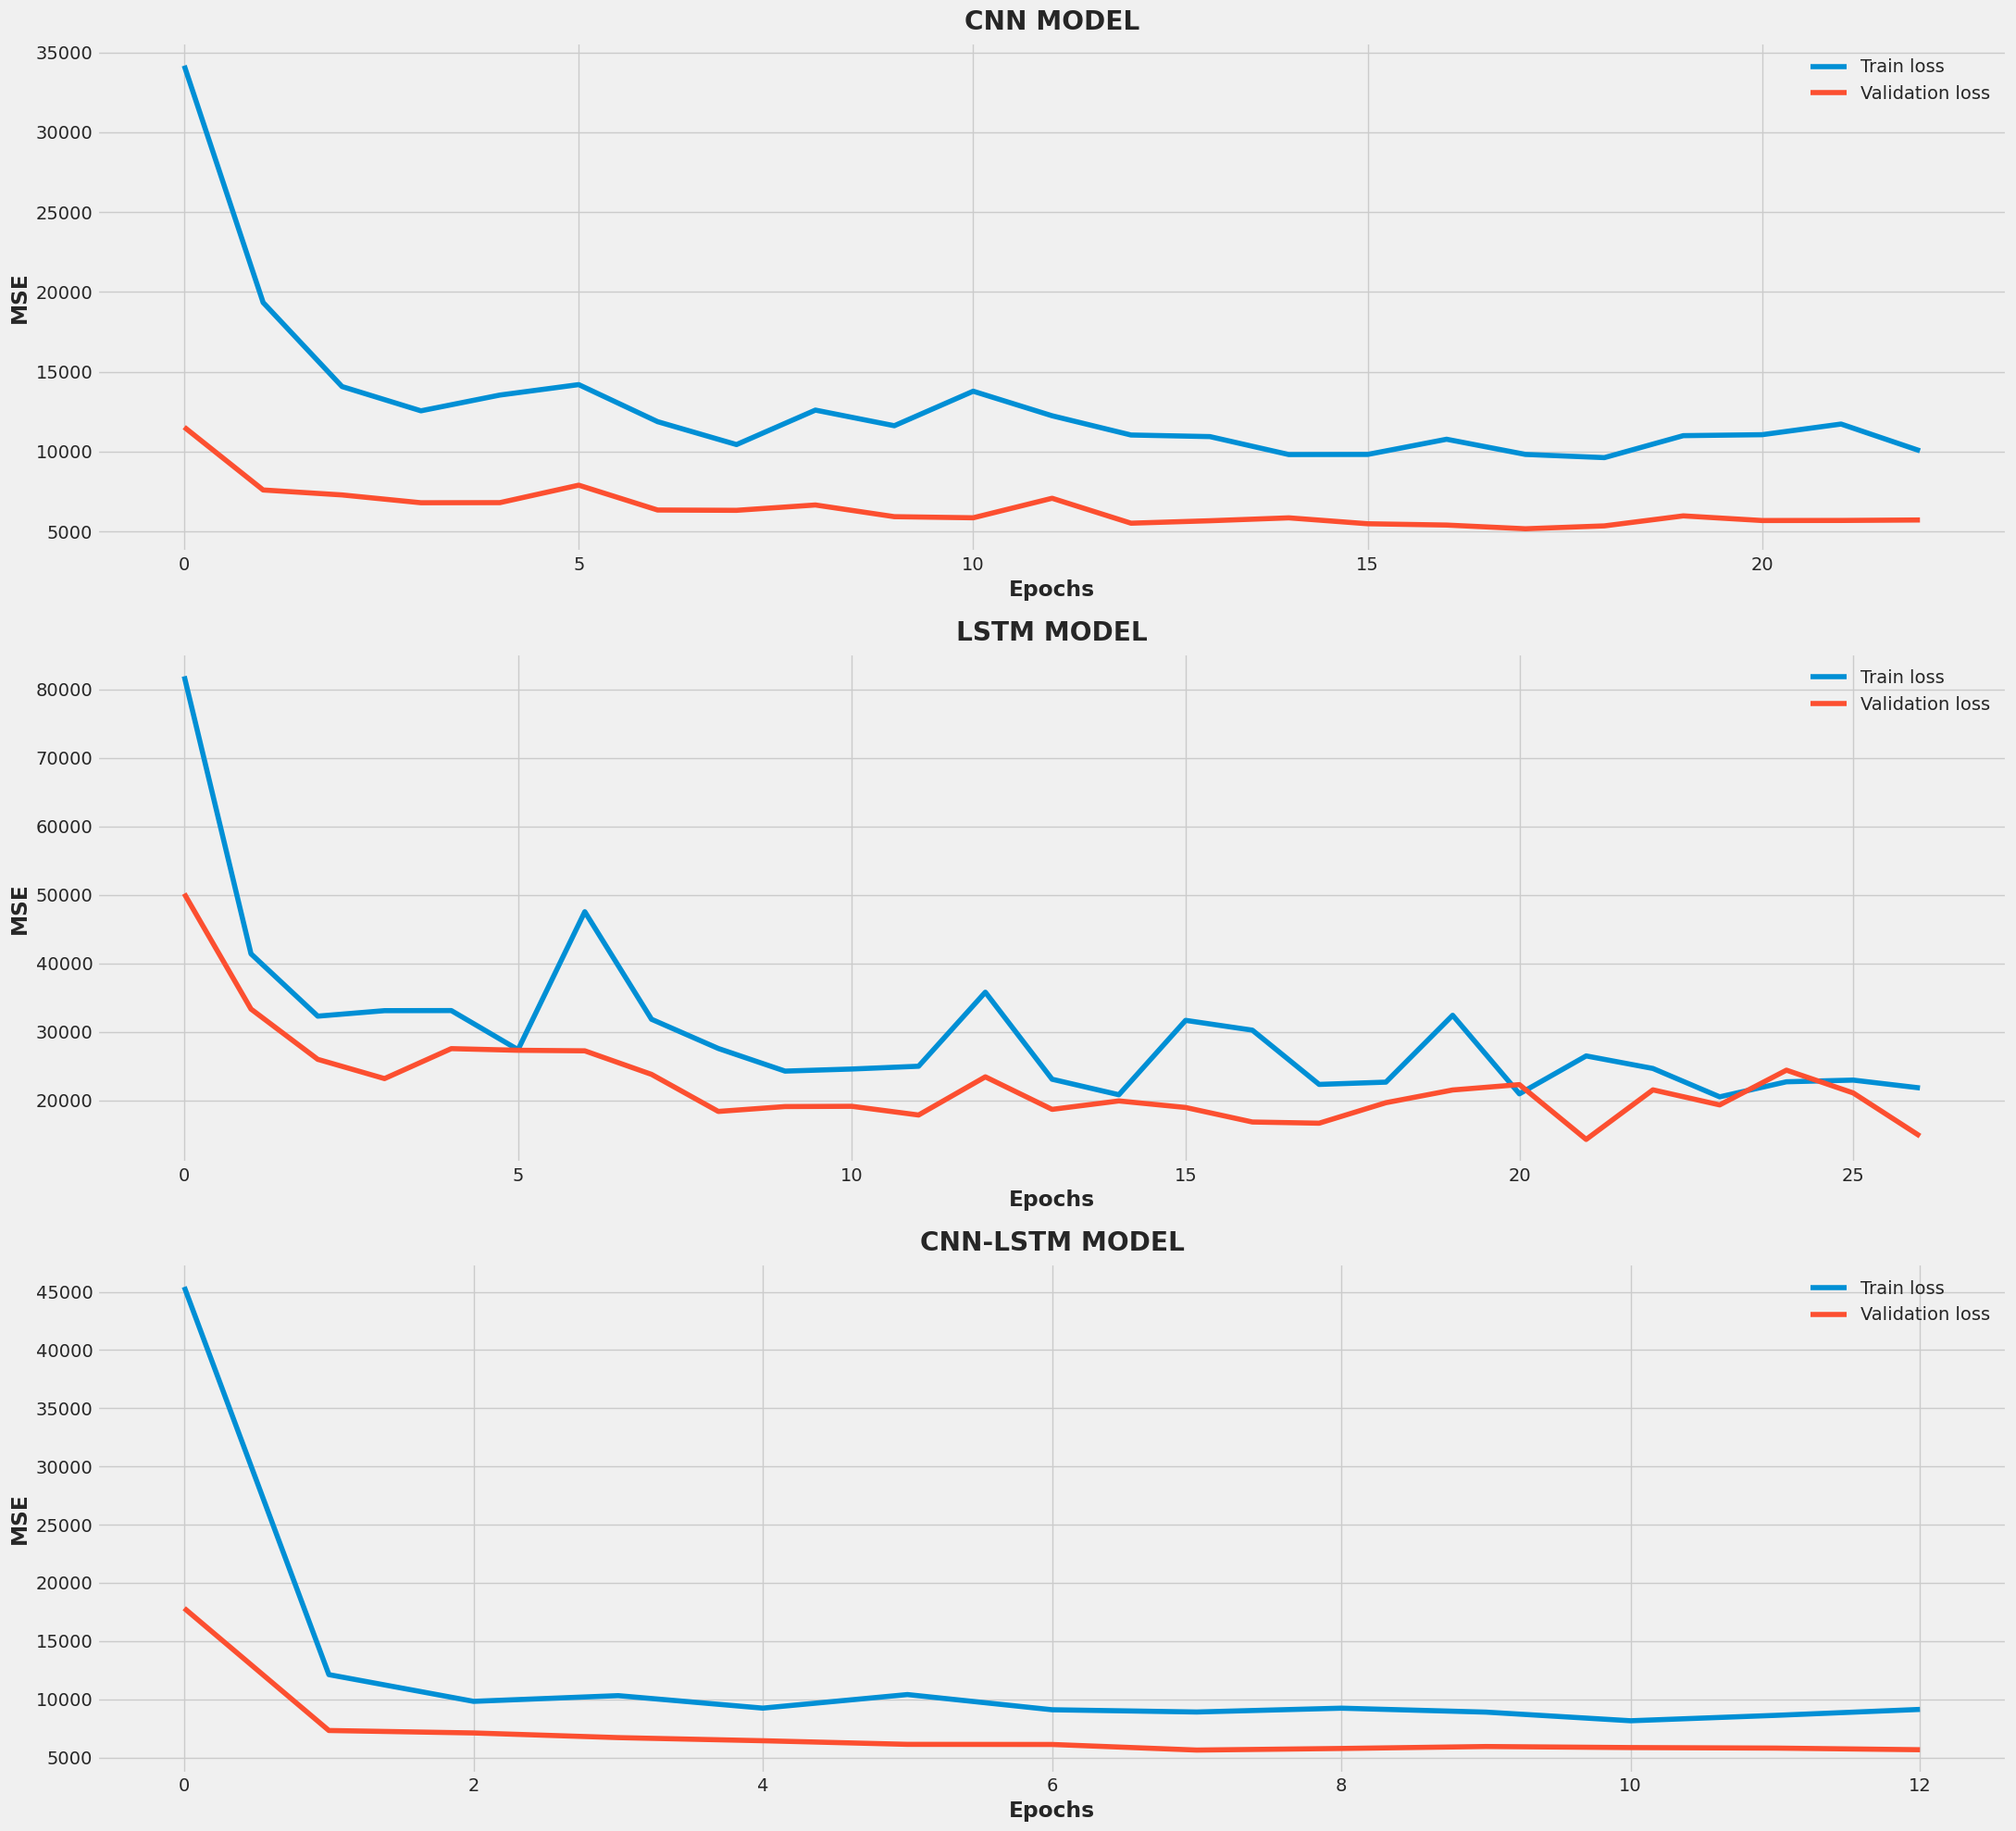

In [50]:
fig, axes = plt.subplots(3, 1, sharey=False,figsize=(22,20))
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]


ax1.plot(cnn_history.history['loss'], label='Train loss')
ax1.plot(cnn_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('CNN MODEL')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(lstm_history.history['loss'], label='Train loss')
ax2.plot(lstm_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('LSTM MODEL')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax3.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('CNN-LSTM MODEL')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')

plt.show()

# Evaluate RMSE

In [51]:
cnn_train_pred = cnn.predict(X_train_series)
cnn_valid_pred = cnn.predict(X_valid_series)
print('Train CNN rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation CNN rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

81/81 [==============================] - 0s 3ms/step
Train CNN rmse: 86.35099891510292
Validation CNN rmse: 75.59129817601577


In [52]:
lstm_train_pred = lstm.predict(X_train_series)
lstm_valid_pred = lstm.predict(X_valid_series)
print('Train LSTM rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation LSTM rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

81/81 [==============================] - 2s 26ms/step
Train LSTM rmse: 129.68698436144186
Validation LSTM rmse: 121.6511579548973


In [53]:
cnn_lstm_train_pred = cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = cnn_lstm.predict(X_valid_series_sub)
print('Train CNN-LSTM rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation CNN-LSTM rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred)))

81/81 [==============================] - 0s 3ms/step
Train CNN-LSTM rmse: 85.8075273182208
Validation CNN-LSTM rmse: 75.28259853416083


# Conclusion

This notebook is an application of some machine learning and deep learning algorithms that I have learned while in the **KaggleX program**. As I kept intuitively experimenting on various network topologies, the more I learned on the effects on performance, precision, stability and accuracy on the different models.

The XGBRegressor model was submitted for this kaggle Sales Forecasting competition with an RMSLE of 0.46808. On some models, I scaled data using MinMax scaler but the RMSLE did not improve and the learning curves were inefficient, even with inverse transform scaler.

Although visualizations of the Seasonal ARIMA model on both the validation and forecasts supports a good prediction model, the neural network models still outperformed the ARIMA.

The CNN model had the better fitting learning curve compared to the other two models. It looks like there was continued training loss up to a point of stability at different epochs. The validation loss also decreased up to a stable constant with a relatively small gap with the training loss. On all three models, the validation data "learned" and followed the same curve as the training data but at different levels. I also tried scaling the data before applying neural network models but all three were inefficient based on poor learning curves. Different learning rates were also explored but a higher than 0.00001 value resulted in models with poor learning curves. 

On the CNN and CNN-LSTM algorithms, the RMSE had lower values but performed differently based on learning curves. The generalization gap on all three models, where the validation loss MSE is slighlty lower than the training loss MSE, makes them a good fit in evaluating performance. The CNN-LSTM model's learning curve showed the validation loss did not learn the data as well as the other 2 models. Based on RMSE of unseen data (validation data), the CNN model's learning curve had the best fit and makes this algorithm the better model.

# References -Thank you!

https://www.kaggle.com/learn/intro-to-deep-learning

https://www.kaggle.com/learn/computer-vision

https://www.tensorflow.org/tutorials/structured_data/time_series

https://keras.io/api/layers/recurrent_layers/

https://www.kaggle.com/code/dimitreoliveira/deep-learning-for-time-series-forecasting

https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/

https://www.kaggle.com/code/datafan07/time-series-analysis-forecast-with-visualization